# Homework 3 Group 7
- First download the CIFAR10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html and put in in a folder called `cifar-10-python` on the same level as this notebook, or change the basepath under `Helper functions`

## General setup

In [1]:
# Main imports
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [2]:
# General tensorflow settings
config = tf.ConfigProto()
# Use GPU in incremental mode (is ignored on CPU version)
config.gpu_options.allow_growth=True
# Add config=config in every tf.Session() -> tf.Session(config=config)

In [3]:
# Helper functions to read/unpickle the dataset
base_path = './cifar-10-python'

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def create_training_tensors_cifar(directory):
    training_data = []
    training_labels = []
    for i in range (1,6):
        filename = directory + 'data_batch_{}'.format(i)
        dictionary = unpickle(filename)
        
        data = dictionary[b'data']
        data = np.reshape(data, newshape=(10000, 3, 32, 32))
        data = np.swapaxes(data, 1, 3)
        data = np.swapaxes(data, 1, 2)
        training_data.append(data)
        
        labels = dictionary[b'labels']
        training_labels.append(labels)
        
    training_data = np.array(training_data)
    training_data = np.reshape(training_data, newshape=(50000,32,32,3))
    training_labels = np.array(training_labels)
    training_labels = np.reshape(training_labels, newshape=(50000,))
    
    return training_data, training_labels
        
    
def create_validation_tensors_cifar(directory):

    filename = directory + 'test_batch'
    dictionary = unpickle(filename)

    data = dictionary[b'data']
    data = np.reshape(data, newshape=(10000, 3, 32, 32))
    data = np.swapaxes(data, 1, 3)
    data = np.swapaxes(data, 1, 2)
    
    labels = dictionary[b'labels']
    labels = np.array(labels)
    
    return data, labels
               
        
training_data, training_labels = create_training_tensors_cifar('{}/cifar-10-batches-py/'.format(base_path))
validation_data, validation_labels = create_validation_tensors_cifar('{}/cifar-10-batches-py/'.format(base_path))


label_to_word = {
    0: "Airplane",
    1: "Autombile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

## Data preparation and visualization

In [4]:
# Print some information about the data
print('Training data shape: {}'.format(training_data.shape))
print('Training labels shape: {}'.format(training_labels.shape))

print('Validation data shape: {}'.format(validation_data.shape))
print('Validation labels shape: {}'.format(validation_labels.shape))

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000,)


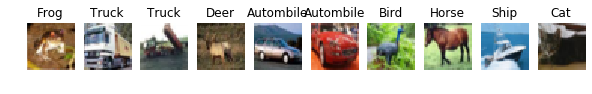

In [5]:
# Visualize the first 10 images from the training data set

# Create a figure with 10 subplots
fig, ax = plt.subplots(1, 10, figsize=(10,10))

# Loop over the 10 subplots and print the corresponding image
for i in range(10):
    # Get the corresponing label and set it as the title of the plot
    ax[i].set_title(label_to_word[training_labels[i]])
    # Show the image 
    ax[i].imshow(training_data[i])
    # Turn axis labeling off
    ax[i].axis("off")

In [6]:
# Create the dataset for tensorflow

# First we reset the graph
tf.reset_default_graph()

# Now we use the tf.data library to create a tensorflow dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# Now we specifiy the respective batch sizes
training_batch_size = 200
validation_batch_size = 10000
training_dataset = training_dataset.batch(training_batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)

# Shuffle the training data in each epoch
training_dataset = training_dataset.shuffle(buffer_size=len(training_data), reshuffle_each_iteration=True)

In [7]:
# Create the iterator 

# First we create the iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

# We name the get_next method of the iterator to use it as a shortcut
next_batch = iterator.get_next()

# We prepare the initializer operations for both the training and the validation dataset
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

## Building the model

![](https://i.imgur.com/fBaZ5k8.png)

In [8]:
# First we will format the data in the correct way

# We define our input data and the corresponding labels
input_data = next_batch[0]
labels = tf.cast(next_batch[1], dtype=tf.int64)

# We have to cast the data to float32 (from uint8)
input_data = tf.cast(input_data, dtype=tf.float32)

# We transform our labels to one hot vectors
one_hot_labels = tf.one_hot(labels, 10)

In [9]:
# Apply the first convolution 
with tf.variable_scope("conv_layer1"):
    kernel_size = 5
    kernel_number = 16
    channels = 3
    stride = 1
    padding = 'SAME'
    activation_function = tf.tanh
    kernels = tf.Variable(tf.truncated_normal([kernel_size,
                                               kernel_size,
                                               channels,
                                               kernel_number],
                                              stddev=0.1))  
    biases = tf.Variable(tf.zeros([kernel_number]))
    convolution = tf.nn.conv2d(input_data,
                              kernels,
                              strides=[1, stride, stride, 1],
                              padding=padding)
    feature_maps1 = activation_function(convolution + biases)   

In [10]:
# Apply the first pooling
with tf.variable_scope("pool_layer1"):
    kernel_size = 2
    stride = 2
    padding = 'SAME'
    pooling1 = tf.nn.max_pool(feature_maps1,
                              ksize=[1, kernel_size, kernel_size, 1],
                              strides=[1, stride, stride, 1],
                              padding=padding)

In [11]:
# Apply the second convolution
with tf.variable_scope("conv_layer2"):
    kernel_size = 3
    kernel_number = 32
    channels = 16
    stride = 1
    padding = 'SAME'
    activation_function = tf.tanh
    kernels = tf.Variable(tf.truncated_normal([kernel_size,
                                               kernel_size,
                                               channels,
                                               kernel_number],
                                              stddev=0.1))  
    biases = tf.Variable(tf.zeros([kernel_number]))
    convolution = tf.nn.conv2d(pooling1,
                              kernels,
                              strides=[1, stride, stride, 1],
                              padding=padding)
    feature_maps2 = activation_function(convolution + biases)   

In [12]:
# Apply the second pooling
with tf.variable_scope("pool_layer2"):
    kernel_size = 2
    stride = 2
    padding = 'SAME'
    pooling2 = tf.nn.max_pool(feature_maps2,
                              ksize=[1, kernel_size, kernel_size, 1],
                              strides=[1, stride, stride, 1],
                              padding=padding)

In [13]:
# Apply the first fully connected layer
with tf.variable_scope("fully1"):
    flat_input = tf.layers.Flatten()(pooling2)
    old_neuron_number = int(flat_input.shape[1])
    neuron_number = 512
    activation_function = tf.tanh
    stddev = 1/tf.sqrt(float(old_neuron_number))
    
    rands = tf.truncated_normal([old_neuron_number, neuron_number], stddev=stddev)
    weights = tf.Variable(rands, dtype=tf.float32)
    biases = tf.Variable(tf.zeros(neuron_number), dtype=tf.float32)

    # Now we will mutiply the input with the weights to get the drive 
    drive = flat_input @ weights + biases

    # And use the activation function
    output = activation_function(drive)     

In [14]:
# Apply the output layer
with tf.variable_scope("output"):
    flat_input = output
    old_neuron_number = int(flat_input.shape[1])
    neuron_number = 10
    activation_function = tf.nn.softmax
    stddev = 1/tf.sqrt(float(old_neuron_number))
    
    rands = tf.truncated_normal([old_neuron_number, neuron_number], stddev=stddev)
    weights = tf.Variable(rands, dtype=tf.float32)
    biases = tf.Variable(tf.zeros(neuron_number), dtype=tf.float32)

    # Now we will mutiply the input with the weights to get the drive (logits)
    logits = flat_input @ weights + biases

    # And use the softmax activation function
    prediction = activation_function(logits)     

In [15]:
# Then we have to define our metrics

# Calculate the cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Define the accuracy
match_bools = tf.equal(labels, tf.argmax(prediction, axis=1))
accuracy = tf.reduce_mean(tf.cast(match_bools, dtype=tf.float32))

In [16]:
# We also have to define our optimizer

# First we need to specify a learning rate 
learning_rate = 1e-4
# Then we create an optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# And tell the optimizer that it should minimize the loss
training_step = optimizer.minimize(loss)

In [17]:
# In the end we will specify some summaries, so that we can visualize our progress with tensorboard

# Specify the variables for the summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

# Now we will merge our two summary scalars
merged_summaries = tf.summary.merge_all()

# We also have two specify two summary file writers 
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs=1)

## Training

In [18]:
# Finally we can train our model

# First we specify the number of epochs
epochs = 5

# We create a saver to save the model and run predictions later on
saver = tf.train.Saver()


# We safely create our tensorflow session and pass our config parameters (for correct GPU usage, if GPU available)
with tf.Session(config=config) as sess:
    
    # We initialize our variables
    sess.run(tf.global_variables_initializer())
    
    # We define a step counter (for the summaries)
    global_step = 0
    
    # We will run our training as often as specified in epochs
    for _ in range(epochs):
        
        # Training Part
        # We have to load the training data into the iterator
        sess.run(training_init_op)
        
        # We have to loop over all our batches in every epoch
        while True:
            try:
                # We train with one batch and read the summary and save it in the variable summary
                _, summary = sess.run((training_step, merged_summaries))
                
                # We write the summary to the disk at the specified location
                train_writer.add_summary(summary, global_step)
                
                # We update our step counter
                global_step += 1
                
            # After we finished all batches, we catch the OutOfRangeError and break
            except tf.errors.OutOfRangeError:
                break
                
        # Validation Part
        # We have to load the validation data into the iterator
        sess.run(validation_init_op)
        # We read out the summary  for the validation data (without training)
        summary, acc = sess.run((merged_summaries, accuracy))
            
        # And we save the summary to the disk
        validation_writer.add_summary(summary, global_step) 
    
    # Save the model at the end
    save_path = './best_data-mnist.ckpt'
    saver.save(sess, save_path)
    print('saving checkpoint with acc.: {} at: {}'.format(acc, save_path))

saving checkpoint with acc.: 0.5403000116348267 at: ./best_data-mnist.ckpt


**Visualization with TensorBoard:** 
- Run `tensorboard --logdir='./summaries'` in the terminal at the same location as this file. If the webbrowser does not start automatically, click on this link http://localhost:6006/ or on the link provided there
- Alternatively, uncomment and run the cell below (wait for the training to finish)

In [19]:
# !tensorboard --logdir='./summaries'

**Screenshots:**
- Accuracy: ![](https://i.imgur.com/P7CHe5o.png)
- Loss: ![](https://i.imgur.com/Q2i6gSv.png)

INFO:tensorflow:Restoring parameters from ./best_data-mnist.ckpt


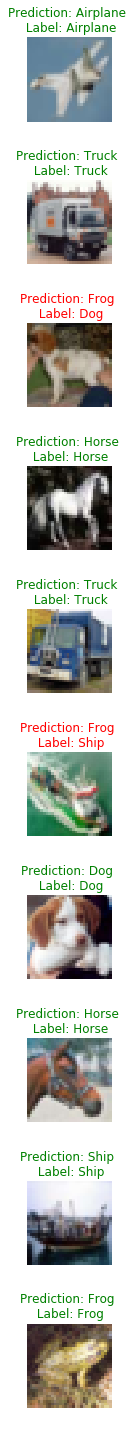

In [20]:
# We run some inference to test our model

# Speficy how many images we want to test and from where to where to choose
test_start = 10
test_end = 20
test_images = validation_data[test_start:test_end]

loader = tf.train.Saver()

with tf.Session(config=config) as sess:
    # Reload the model
    loader.restore(sess, "./best_data-mnist.ckpt")
    
    pred = sess.run(prediction, feed_dict={input_data: test_images})
    pred_labels = np.argmax(pred, axis=1)

    # Create a figure with number of images subplots
    number_images = len(test_images)
    fig, ax = plt.subplots(number_images, 1, figsize=(5,20))

    # Loop over the subplots and print the corresponding image and the prediction and the label
    for i in range(number_images):
        # Correct or incorrect?
        color = 'green' if pred_labels[i] == validation_labels[test_start+i] else 'red'
        # Get the corresponing label and set it as the title of the plot
        ax[i].set_title('Prediction: {} \n Label: {}'.format(
            label_to_word[pred_labels[i]],
                          label_to_word[validation_labels[test_start+i]]), color=color)
        # Show the image 
        ax[i].imshow(test_images[i])
        # Turn axis labeling off
        ax[i].axis("off")
        plt.tight_layout()
